<a href="https://colab.research.google.com/github/Mahdi-Abdollahii/NGC_6822/blob/main/NGC6822_SFH_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Mahdi-Abdollahii/NGC_6822.git

Cloning into 'NGC_6822'...
remote: Enumerating objects: 1126, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 1126 (delta 244), reused 362 (delta 208), pack-reused 665
Receiving objects: 100% (1126/1126), 94.17 MiB | 12.38 MiB/s, done.
Resolving deltas: 100% (524/524), done.
Updating files: 100% (131/131), done.


In [ ]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import pylab as py
from matplotlib import gridspec
import numpy as np
import pandas as pd
import math
import scipy.integrate as integrate
pd.options.mode.chained_assignment = None  # default='warn'

from astropy.io import ascii
import csv
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import matplotlib.markers as mmark
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerBase
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator

import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import host_subplot
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def Ellipse(x,a,b):
  '''
   a: semi-major axis
   b: semi-minor axis
  '''
  y = b * ((1 - ((x/a)**2) )**0.5)
  return y

In [ ]:
DM = 23.45 # based on sibbons => (Mateo 1998; Lee et al. 1993)

Av = 0.77  # based on whitelock 2012
Aj = 0.2   # based on whitelock 2012
Ah = 0.12  # based on whitelock 2012
Ak = 0.07  # based on whitelock 2012

RGBT = 17.42 # based on whitelock 2012

Ra_center = 296.23 #degree
Dec_center = -14.80167 #degree

Distance = 500 #Kpc
a_bulge = 0.560 #Kpc
b_nulge = 0.727 #Kpc
R_body = 1.4 #Kpc

S_bulge = np.pi * a_bulge * b_nulge # Kpc^2
S_body  = np.pi * (R_body**2) - S_bulge  # Kpc^2

# Data Preparing

In [ ]:
df_loc = pd.read_csv('/content/NGC_6822/Data/Data_location.csv')

# Whole

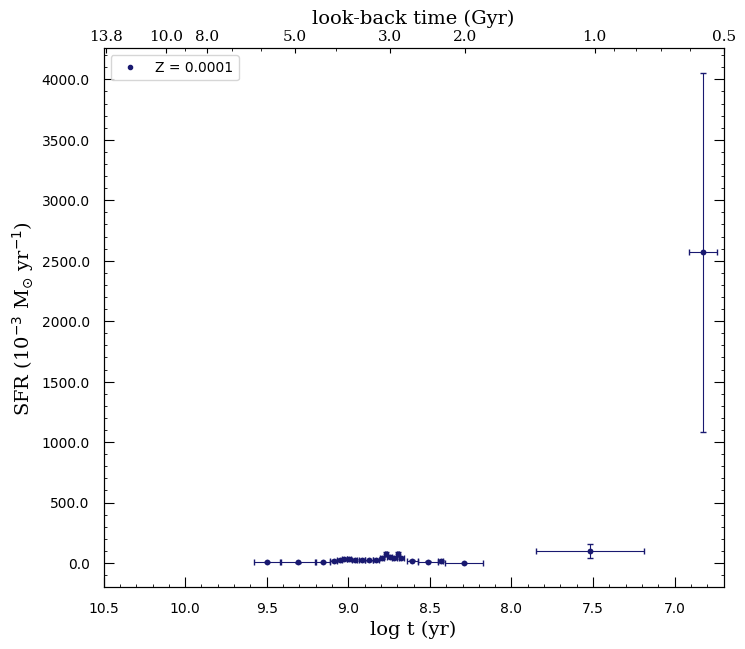

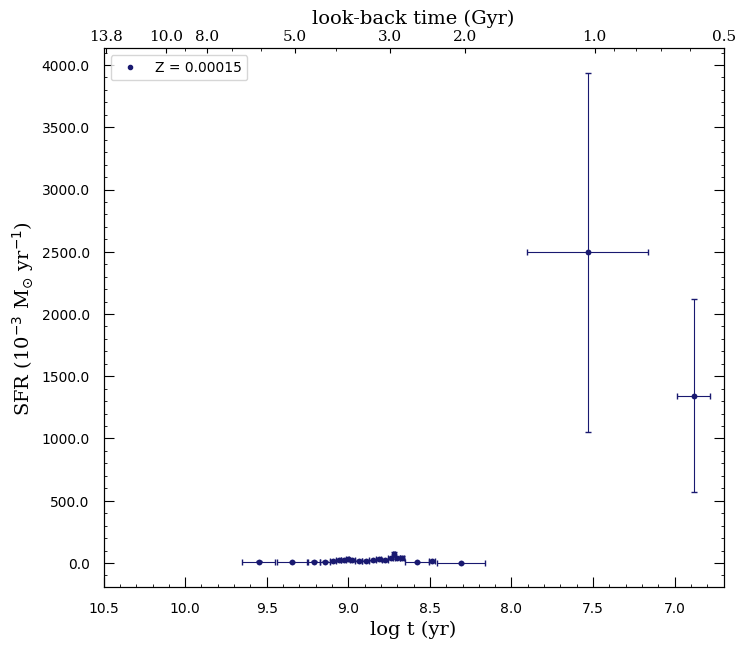

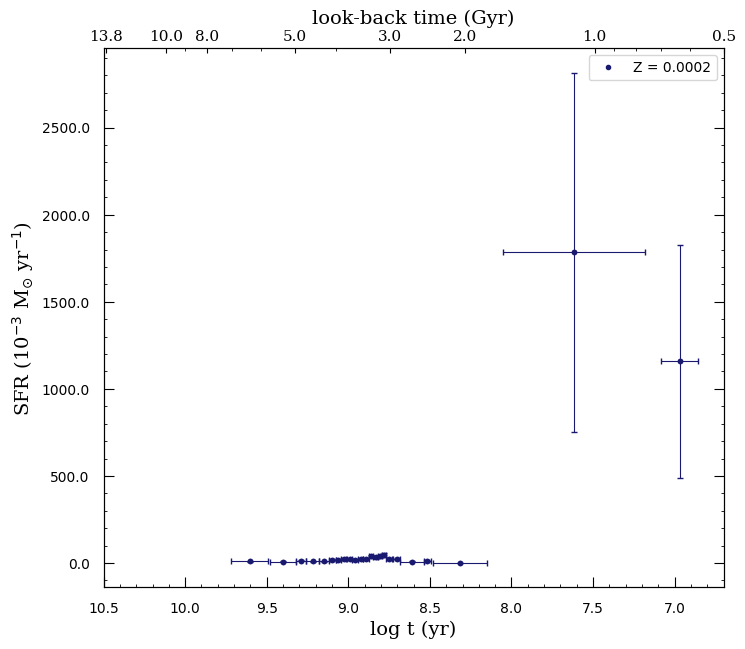

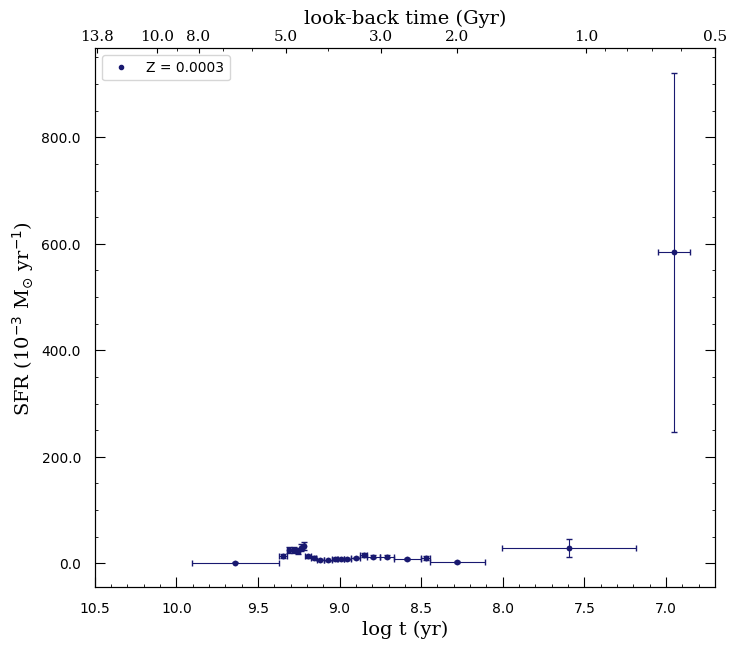

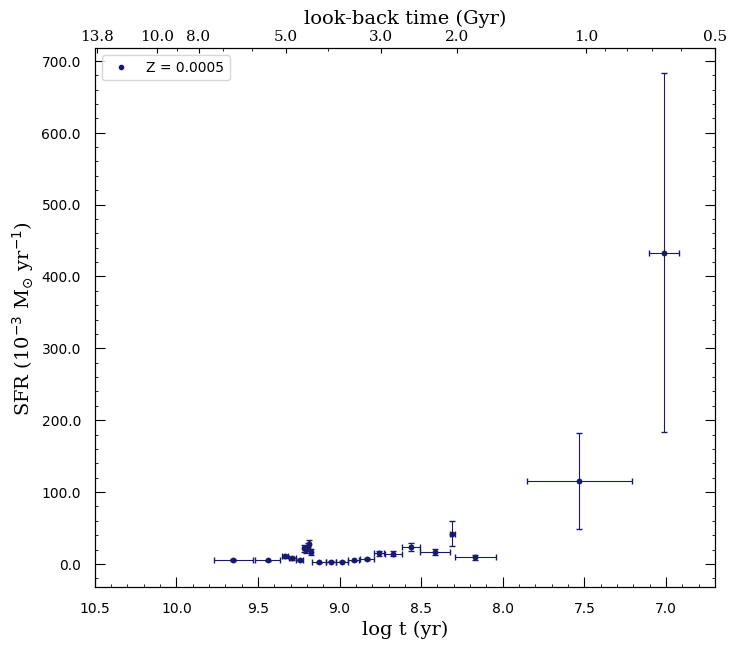

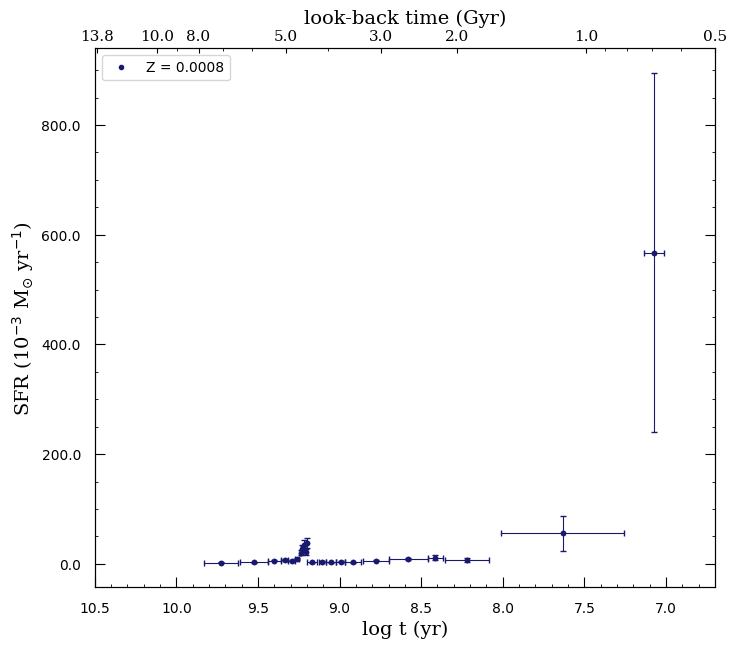

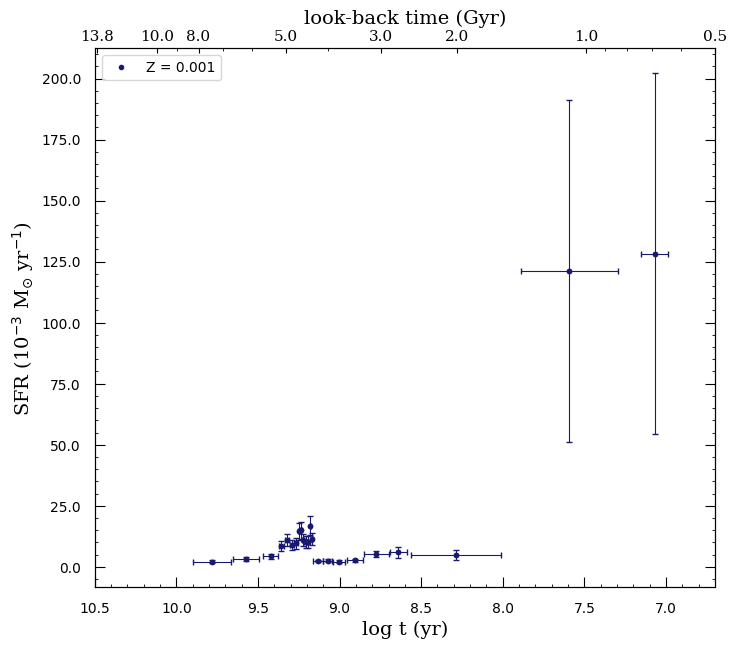

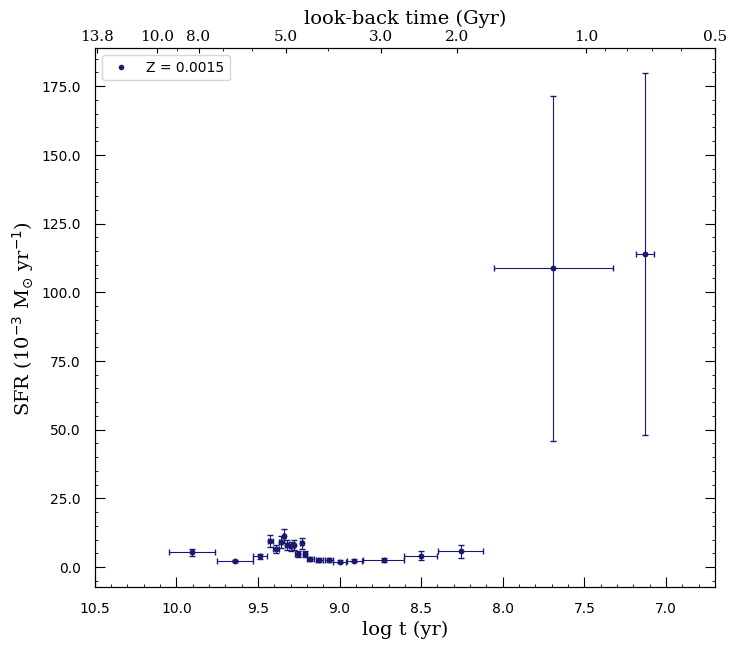

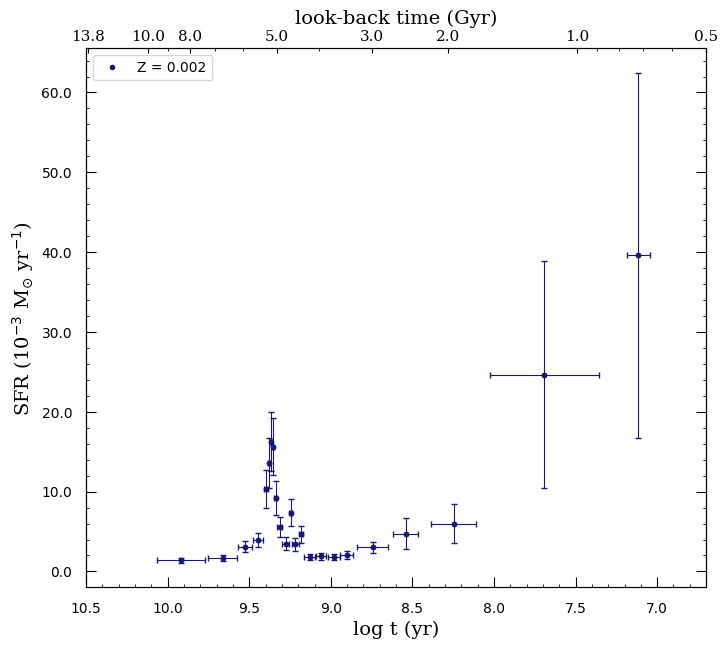

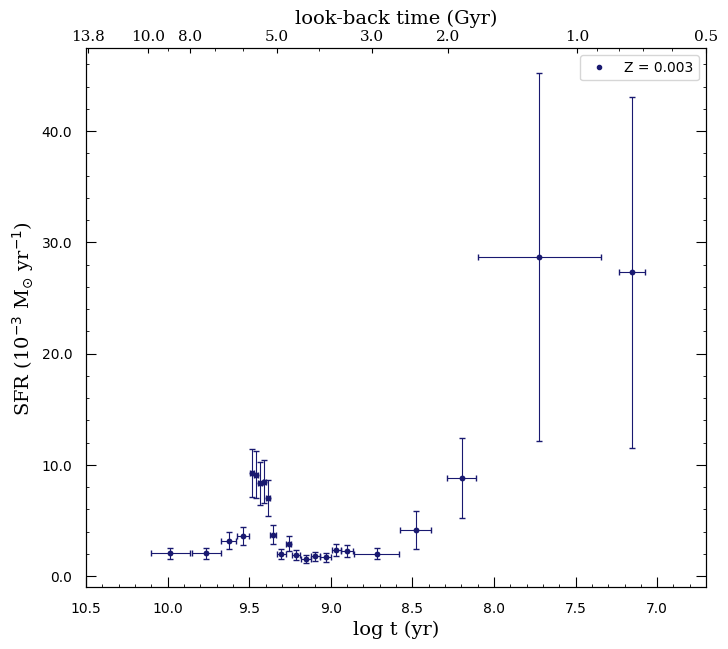

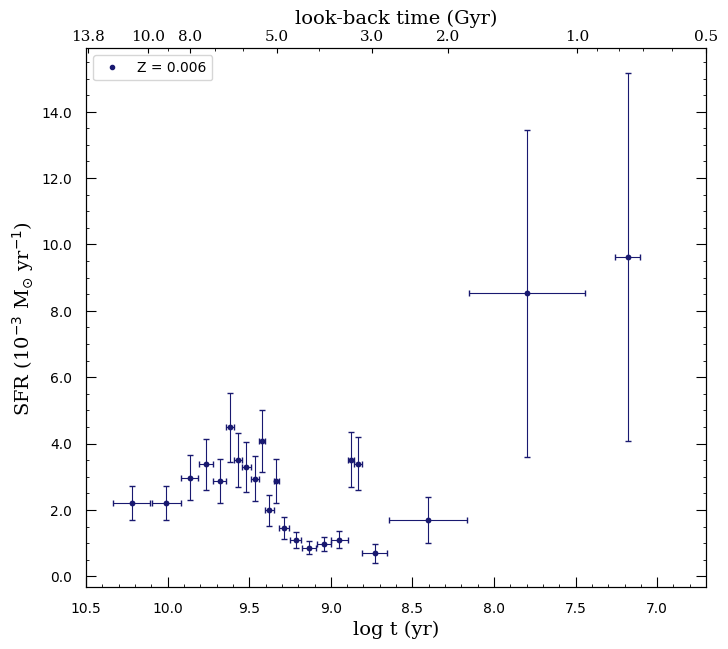

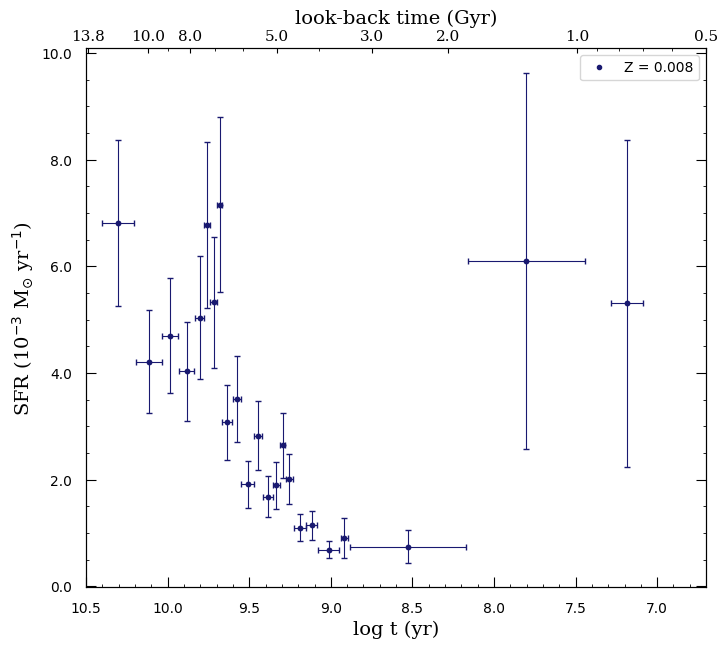

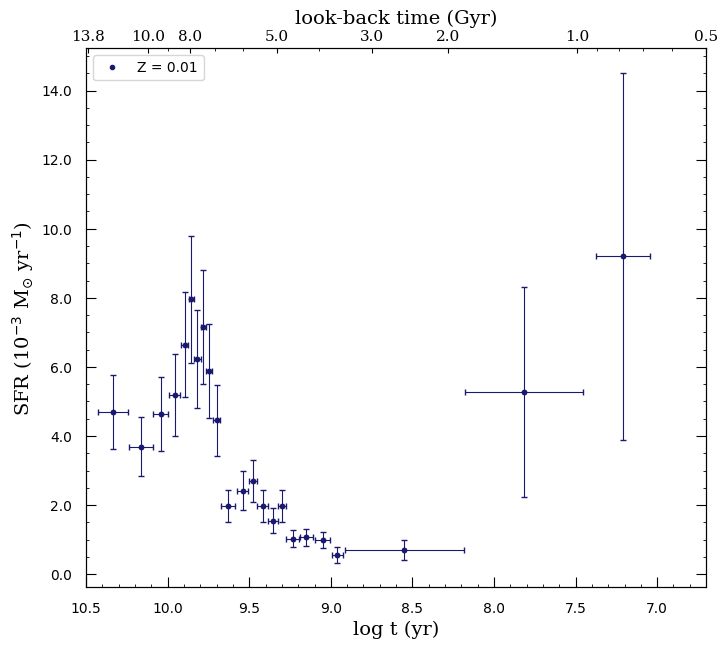

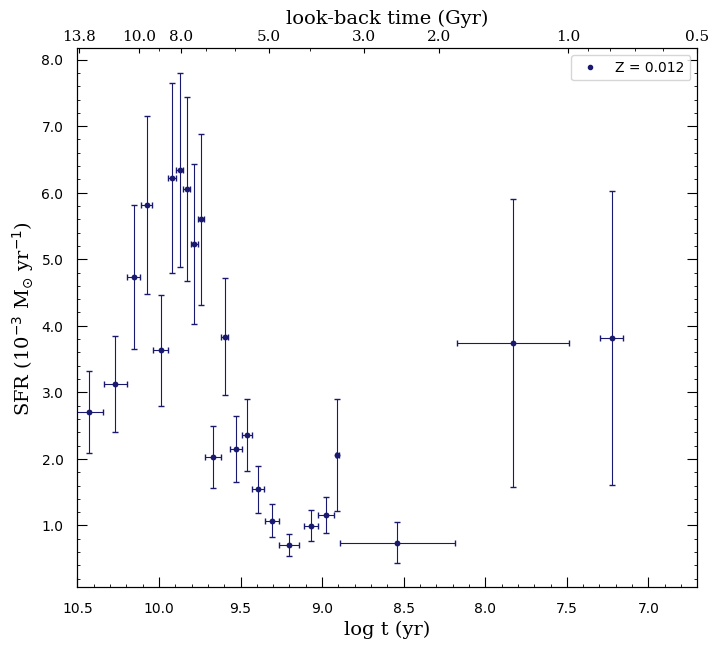

In [ ]:
Z = [0.0001,0.00015,0.0002,0.0003,0.0005,0.0008,
     0.001,0.0015,0.002,0.003,0.006,0.008,
     0.01,0.012]
for w in Z : 
  Z_name = ''.join(list(str(w))[2:])
  df = pd.read_csv('/content/NGC_6822/Data_Correction_v2/NGC6822_LPV_Data_'+Z_name+'.csv')
  df = df.merge(df_loc, how='inner', on = ['Ra(J2000) deg','Dec(J2000) deg'])

  #Sorting By t (Age of LPV Stras)
  df = df.sort_values(by='t', ascending=False)
  df = df.reset_index()

  #Finding Alpha
  df['alpha'] = np.nan
  for k in df.index:
    if df.loc[k,'M/Ms'] < 0.08 :
      df.loc[k,'alpha'] = 0.3
    elif df.loc[k,'M/Ms'] >= 0.5 :
      df.loc[k,'alpha'] = 2.3
    else :
      df.loc[k,'alpha'] = 1.3 

  # Whole Region
  # Setting populatopn of each bins
  bins_number = 19
  bins_with_less_stars = 2
  bins_pop = ([19]*(bins_number-bins_with_less_stars)) + ([18]*bins_with_less_stars) + ( [6] * 2 ) + ( [3] * 2)

  #SFH Calcualtion
  lower_index = 0
  sub_integration = 0
  
  sub_integration = integrate.quad(lambda m: m * m**-0.3 , 0.02, 0.08)[0] \
                    + integrate.quad(lambda m: m * m**-1.3 , 0.08, 0.5)[0] \
                      + integrate.quad(lambda m: m * m**-2.3 , 0.5, 200)[0]

  log_t = []
  log_t_err = []

  XI = []
  XI_err = []

  alpha =[]
  M_lower_limit = []
  M_upper_limit = []
  log_t_lower_limit = []
  log_t_upper_limit = []

  for i in bins_pop :

    selected_df = df[lower_index:lower_index+i]

    # Calculating limitation of each bin 
    M_lower_limit_ = selected_df.iloc[0]['M/Ms']
    M_upper_limit_ = selected_df.iloc[-1]['M/Ms']
    alpha_ = selected_df.iloc[0]['alpha']
    log_t_lower_limit_ = selected_df.iloc[-1]['Log(t)']
    log_t_upper_limit_ = selected_df.iloc[0]['Log(t)']

    # Adding to lists
    alpha.append(alpha_)
    M_lower_limit.append(M_lower_limit_)
    M_upper_limit.append(M_upper_limit_)
    log_t_lower_limit.append(log_t_lower_limit_)
    log_t_upper_limit.append(log_t_upper_limit_)

    # Calculating XI
    p1 = sum(1/selected_df['dt'])
    p2 = sub_integration
    p3 , err = integrate.quad(lambda m: m**(-alpha_) , M_lower_limit_, M_upper_limit_)
    
    XI_ = p1 * p2 * (1/p3) * 1000
    XI_err_ = XI_ * ((i**0.5)/i) 

    log_t.append((log_t_lower_limit_ + log_t_upper_limit_)/2)
    log_t_err.append((log_t_upper_limit_ - log_t_lower_limit_ )/2)
    XI.append(XI_)
    XI_err.append(XI_err_)

    lower_index += i
    
  # Making Data frame for SFH calculation
  columns = ['log(t) (lower limit)' , 'log(t) (upper limit)',
            'M (lower limit)', 'M (upper limit)' , 'Alpha' , 'Mean log(t)',
            'Mean log(t) error' , 'XI' , 'XI error']
  
  # Calling DataFrame constructor after zipping
  # both lists, with columns specified
  SFH_df = pd.DataFrame(list(zip(log_t_lower_limit, log_t_upper_limit,
                                M_lower_limit,M_upper_limit,alpha,log_t,
                                log_t_err,XI,XI_err)), columns =columns)

  #Plot
  plt.figure(figsize = (8,7), dpi = 100)

  plt.xlabel('log t (yr)', {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})
  plt.ylabel('SFR (10$^{-3}$ M$_{\odot}$ yr$^{-1}$)',
            {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})

  plt.tick_params(axis='both', which='major', length=7, pad=10, direction='in')
  plt.tick_params(axis='y', which='both', left=True, direction='in')
  plt.tick_params(axis='x', which='both', bottom=True, direction='in')
  plt.tick_params(axis='x', which='both', top=True, direction='in')
  plt.tick_params(axis='y', which='both', right=True, direction='in')

  plt.minorticks_on()

  plt.xlim(10.5,6.7)

  plt.plot( SFH_df['Mean log(t)'] , SFH_df['XI'] , '.', color = 'midnightblue', label = 'Z = ' + str(w))
  plt.errorbar(SFH_df['Mean log(t)'], SFH_df['XI'] ,
              SFH_df['XI error'] ,SFH_df['Mean log(t) error'], fmt='.', color='midnightblue', capsize=2.5, linewidth=0.8)

  plt.legend()

  ###########################################
  ax2 = plt.twiny()

  ax2.xaxis.tick_top()
  ax2.yaxis.tick_right()
  ax2.set_xlim(13.96,0.575)

  ax2.set_xscale('log')

  ax2.set_xlabel('look-back time (Gyr)', {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})
  ax2.xaxis.set_label_position('top') 
  ax2.yaxis.set_label_position('right') 
  ax2.set_xticks((13.8,10,8,5,3,2,1,0.5))
  ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter(useOffset=None, useMathText=None, useLocale=None))
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=12,fontname = "serif")
  ax2.set_xticklabels(ax2.get_xticks(), fontsize=11,fontname = "serif")

  ax2.tick_params(axis='x',which='both',bottom= False,top= True,direction='in')#,color='red',width=5)
  ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
  ax2.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
  ###########################################

  #Saving Data
  SFH_df.to_csv('/content/Whole_Area/NGC6822_SFH_Data_'+ Z_name +'.csv', index=False)
  plt.savefig('/content/Whole_Area/SFR-'+Z_name+'.jpeg', bbox_inches='tight', dpi = 400)

# Bulge ( a = 3.85 arcmin = 0.06416667 degree, b = 5 arcmin = 0.0833333 degree )

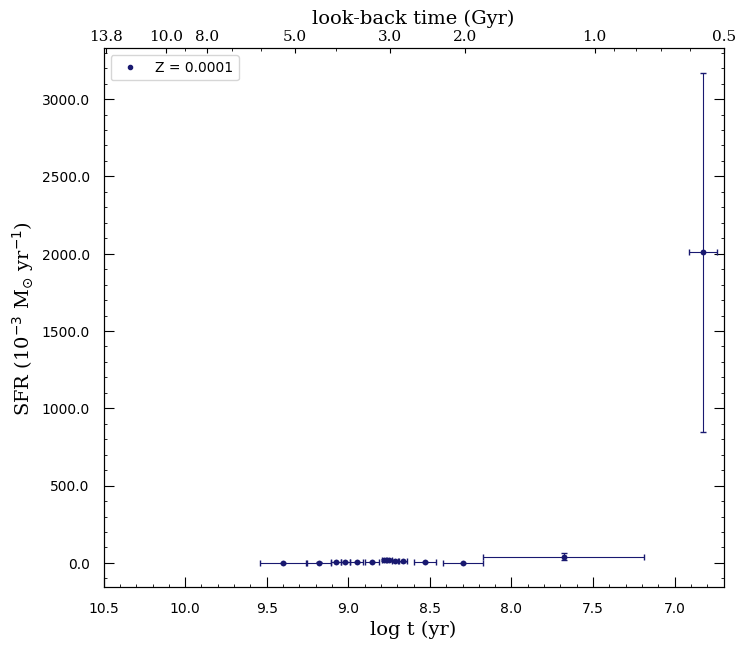

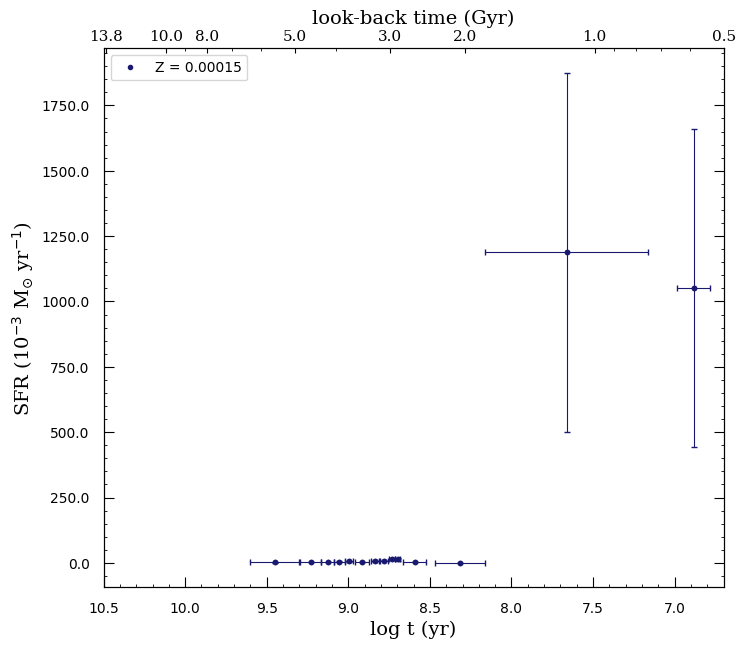

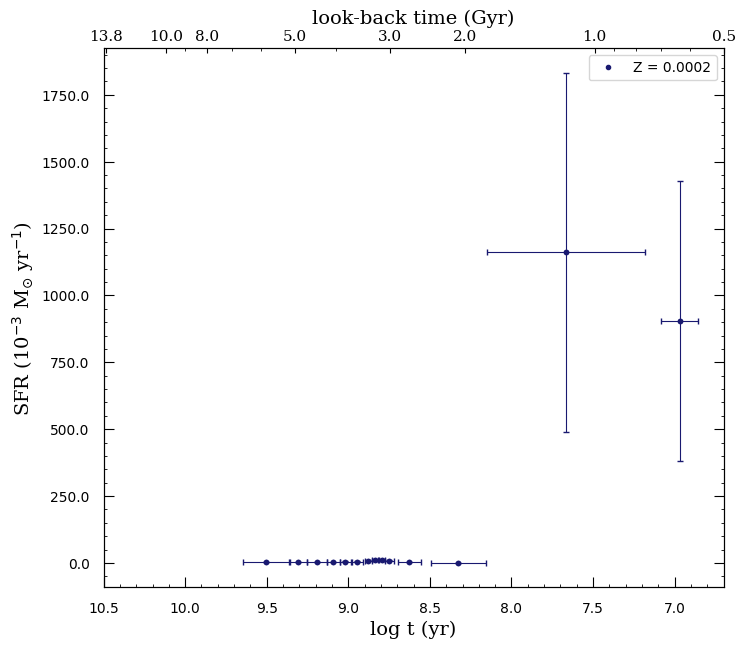

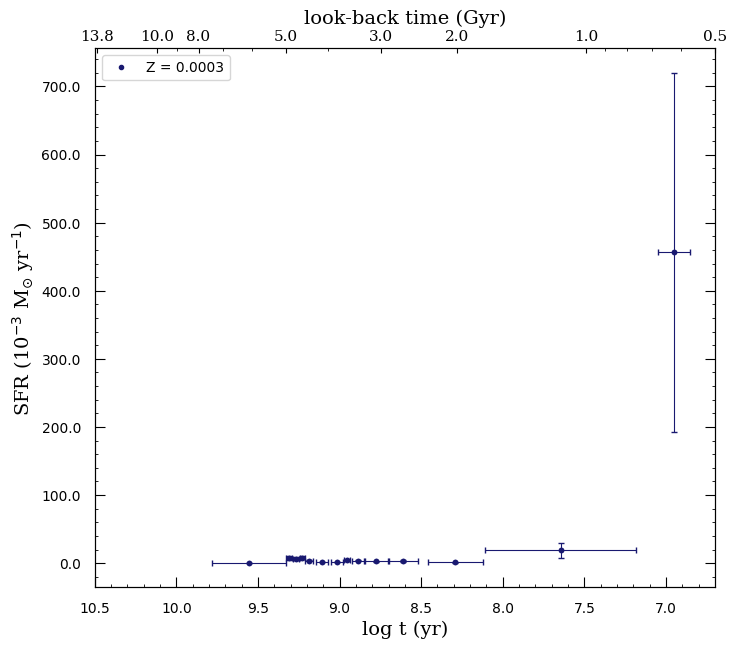

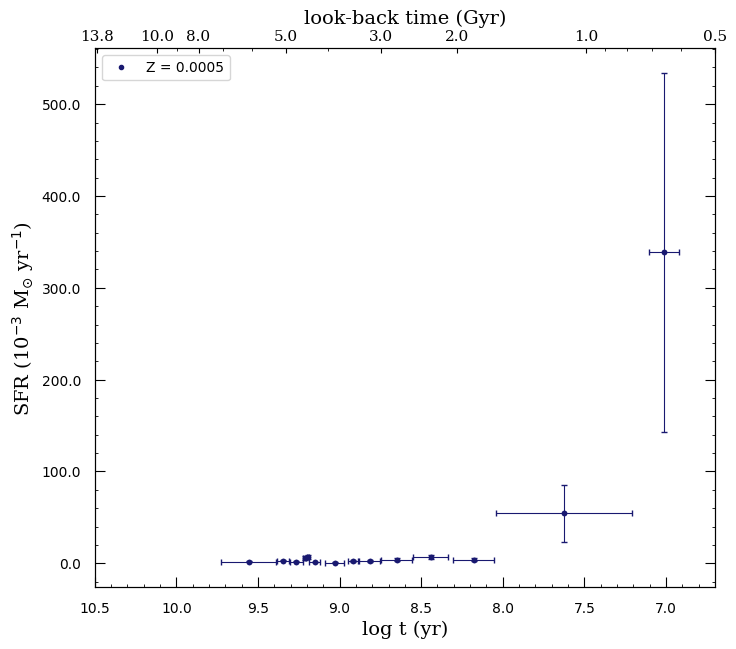

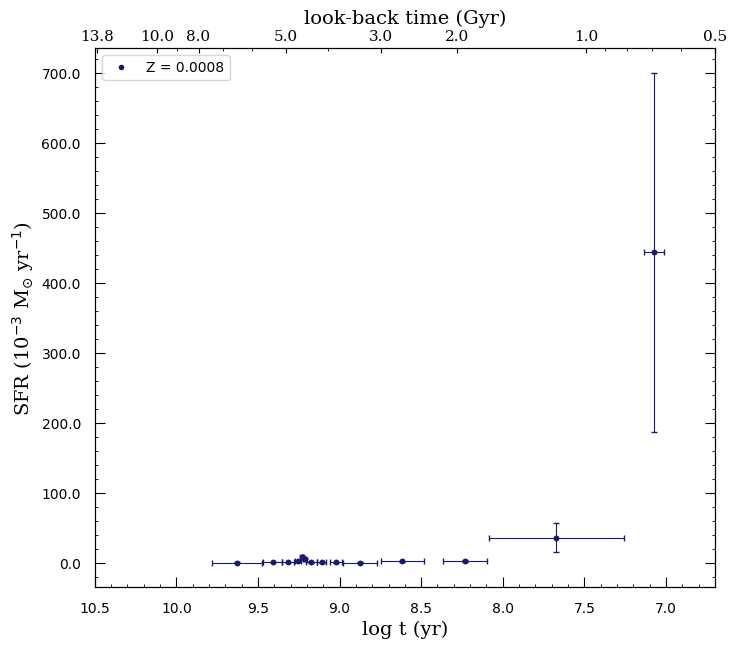

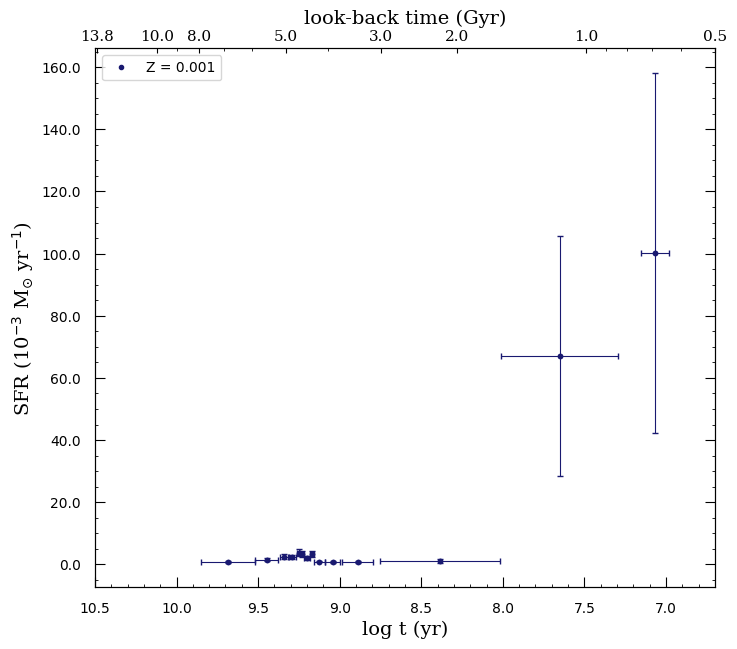

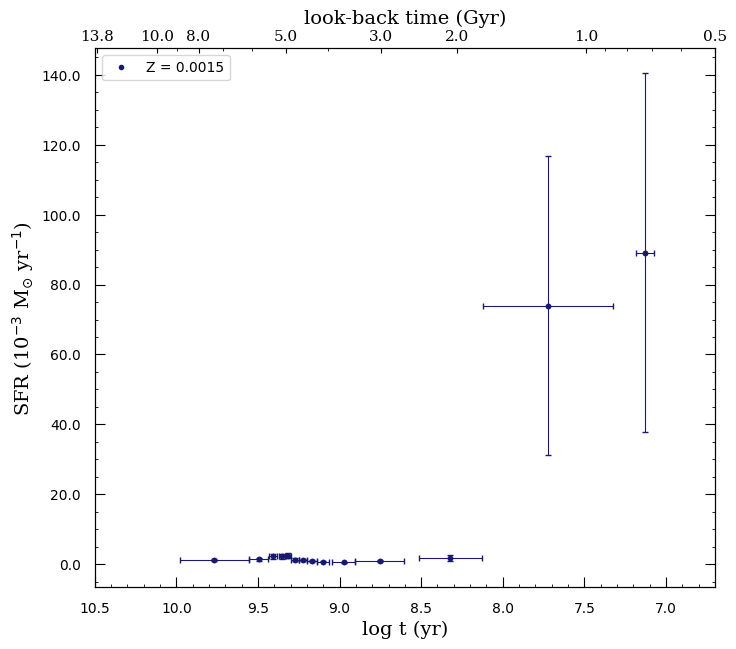

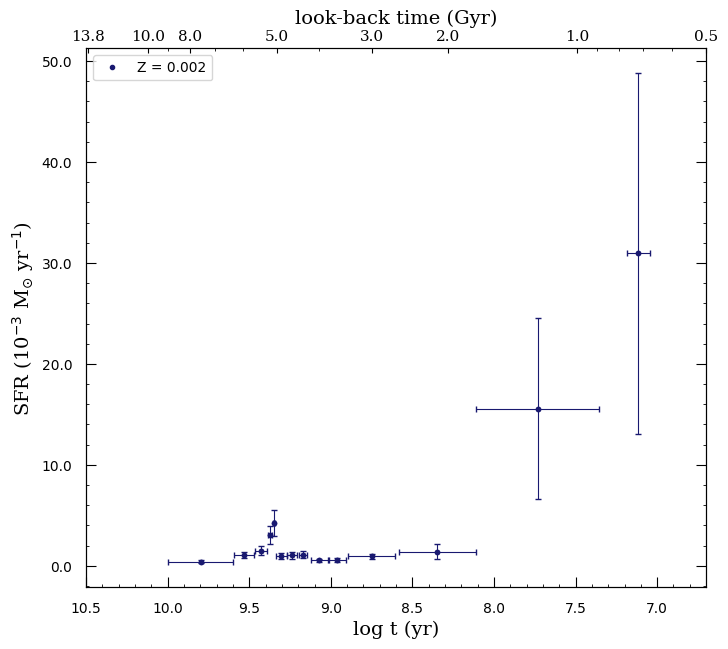

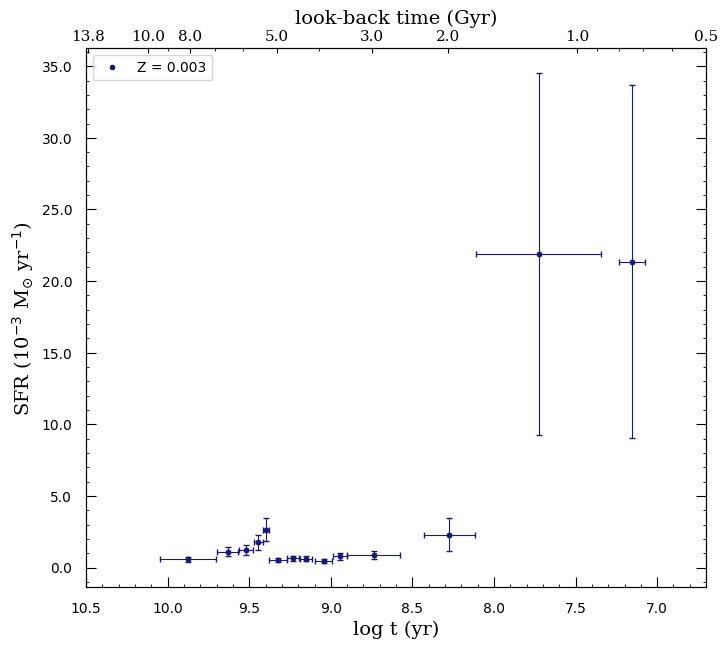

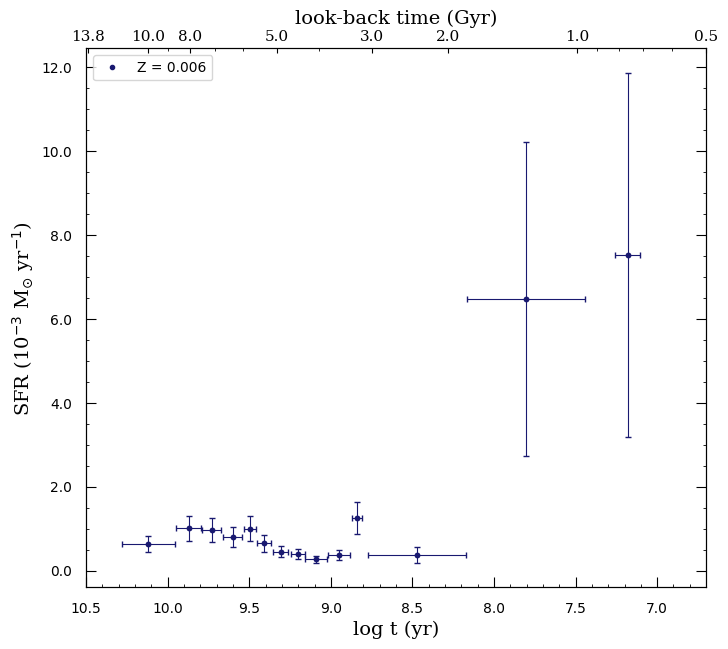

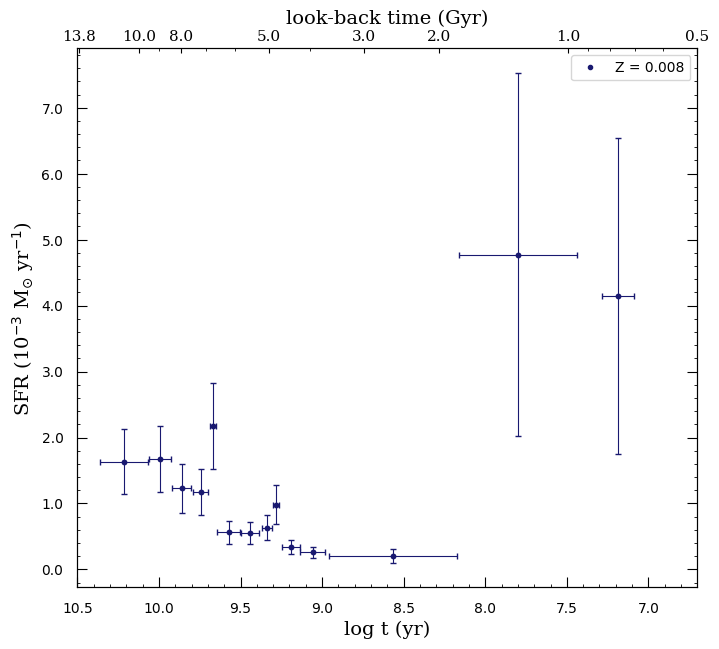

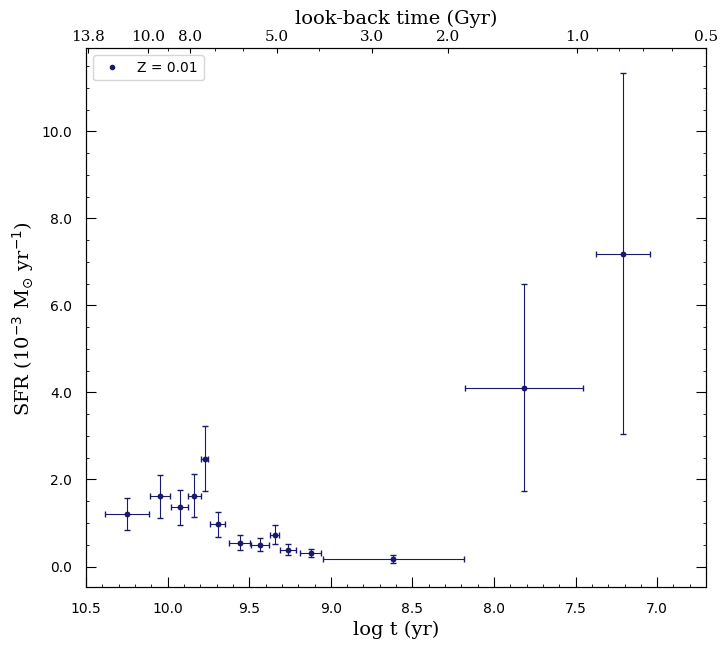

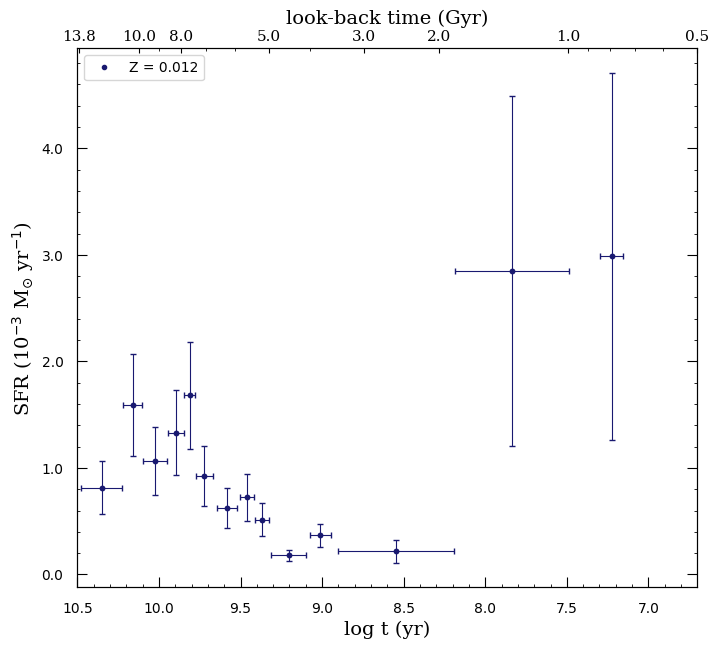

In [ ]:
Z = [0.0001,0.00015,0.0002,0.0003,0.0005,0.0008,
     0.001,0.0015,0.002,0.003,0.006,0.008,
     0.01,0.012]
for w in Z : 
  Z_name = ''.join(list(str(w))[2:])
  df = pd.read_csv('/content/NGC_6822/Data_Correction_v2/NGC6822_LPV_Data_'+Z_name+'.csv')
  df = df.merge(df_loc, how='inner', on = ['Ra(J2000) deg','Dec(J2000) deg'])
  df = df[df['Bulge'] == 1 ]

  #Sorting By t (Age of LPV Stras)
  df = df.sort_values(by='t', ascending=False)
  df = df.reset_index()

  #Finding Alpha
  df['alpha'] = np.nan
  for k in df.index:
    if df.loc[k,'M/Ms'] < 0.08 :
      df.loc[k,'alpha'] = 0.3
    elif df.loc[k,'M/Ms'] >= 0.5 :
      df.loc[k,'alpha'] = 2.3
    else :
      df.loc[k,'alpha'] = 1.3 

  # Whole Region
  # Setting populatopn of each bins 
  bins_number = 11
  bins_with_less_stars = 0
  bins_pop = ([11]*(bins_number-bins_with_less_stars)) + ([10]*bins_with_less_stars) + ([4]) + ( [3] * 2 )

  #SFH Calcualtion
  lower_index = 0
  sub_integration = 0
  
  sub_integration = integrate.quad(lambda m: m * m**-0.3 , 0.02, 0.08)[0] \
                    + integrate.quad(lambda m: m * m**-1.3 , 0.08, 0.5)[0] \
                      + integrate.quad(lambda m: m * m**-2.3 , 0.5, 200)[0]

  log_t = []
  log_t_err = []

  XI = []
  XI_err = []

  alpha =[]
  M_lower_limit = []
  M_upper_limit = []
  log_t_lower_limit = []
  log_t_upper_limit = []

  for i in bins_pop :

    selected_df = df[lower_index:lower_index+i]

    # Calculating limitation of each bin 
    M_lower_limit_ = selected_df.iloc[0]['M/Ms']
    M_upper_limit_ = selected_df.iloc[-1]['M/Ms']
    alpha_ = selected_df.iloc[0]['alpha']
    log_t_lower_limit_ = selected_df.iloc[-1]['Log(t)']
    log_t_upper_limit_ = selected_df.iloc[0]['Log(t)']

    # Adding to lists
    alpha.append(alpha_)
    M_lower_limit.append(M_lower_limit_)
    M_upper_limit.append(M_upper_limit_)
    log_t_lower_limit.append(log_t_lower_limit_)
    log_t_upper_limit.append(log_t_upper_limit_)

    # Calculating XI
    p1 = sum(1/selected_df['dt'])
    p2 = sub_integration
    p3 , err = integrate.quad(lambda m: m**(-alpha_) , M_lower_limit_, M_upper_limit_)
    
    XI_ = p1 * p2 * (1/p3) / S_bulge * 1000
    XI_err_ = XI_ * ((i**0.5)/i) 

    log_t.append((log_t_lower_limit_ + log_t_upper_limit_)/2)
    log_t_err.append((log_t_upper_limit_ - log_t_lower_limit_ )/2)
    XI.append(XI_)
    XI_err.append(XI_err_)

    lower_index += i
    
  # Making Data frame for SFH calculation
  columns = ['log(t) (lower limit)' , 'log(t) (upper limit)',
            'M (lower limit)', 'M (upper limit)' , 'Alpha' , 'Mean log(t)',
            'Mean log(t) error' , 'XI' , 'XI error']
  
  # Calling DataFrame constructor after zipping
  # both lists, with columns specified
  SFH_df = pd.DataFrame(list(zip(log_t_lower_limit, log_t_upper_limit,
                                M_lower_limit,M_upper_limit,alpha,log_t,
                                log_t_err,XI,XI_err)), columns =columns)

  #Plot
  plt.figure(figsize = (8,7), dpi = 100)

  plt.xlabel('log t (yr)', {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})
  plt.ylabel('SFR (10$^{-3}$ M$_{\odot}$ yr$^{-1}$)',
            {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})

  plt.tick_params(axis='both', which='major', length=7, pad=10, direction='in')
  plt.tick_params(axis='y', which='both', left=True, direction='in')
  plt.tick_params(axis='x', which='both', bottom=True, direction='in')
  plt.tick_params(axis='x', which='both', top=True, direction='in')
  plt.tick_params(axis='y', which='both', right=True, direction='in')

  plt.minorticks_on()

  plt.xlim(10.5,6.7)

  plt.plot( SFH_df['Mean log(t)'] , SFH_df['XI'] , '.', color = 'midnightblue', label = 'Z = ' + str(w))
  plt.errorbar(SFH_df['Mean log(t)'], SFH_df['XI'] ,
              SFH_df['XI error'] ,SFH_df['Mean log(t) error'], fmt='.', color='midnightblue', capsize=2.5, linewidth=0.8)

  plt.legend()

  ###########################################
  ax2 = plt.twiny()

  ax2.xaxis.tick_top()
  ax2.yaxis.tick_right()
  ax2.set_xlim(13.96,0.575)

  ax2.set_xscale('log')

  ax2.set_xlabel('look-back time (Gyr)', {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})
  ax2.xaxis.set_label_position('top') 
  ax2.yaxis.set_label_position('right') 
  ax2.set_xticks((13.8,10,8,5,3,2,1,0.5))
  ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter(useOffset=None, useMathText=None, useLocale=None))
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=12,fontname = "serif")
  ax2.set_xticklabels(ax2.get_xticks(), fontsize=11,fontname = "serif")

  ax2.tick_params(axis='x',which='both',bottom= False,top= True,direction='in')#,color='red',width=5)
  ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
  ax2.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
  ###########################################

  #Saving Data
  SFH_df.to_csv('/content/Bulge/NGC6822_SFH_Data_Bulge_'+ Z_name +'.csv', index=False)
  plt.savefig('/content/Bulge/SFR_Bulge_'+Z_name+'.jpeg', bbox_inches='tight', dpi = 400)

# Bulge _ Optical Body Radius  ( Ellipse < R < 1.4 Kpc ) 

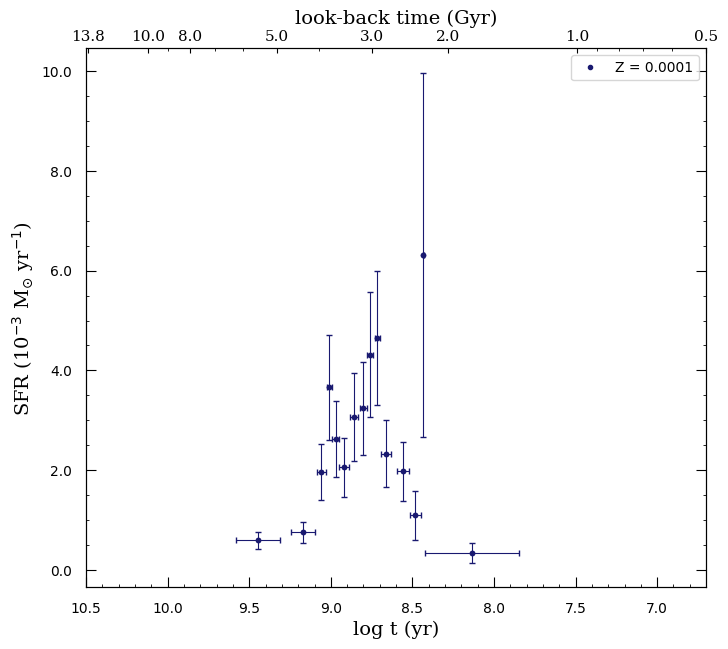

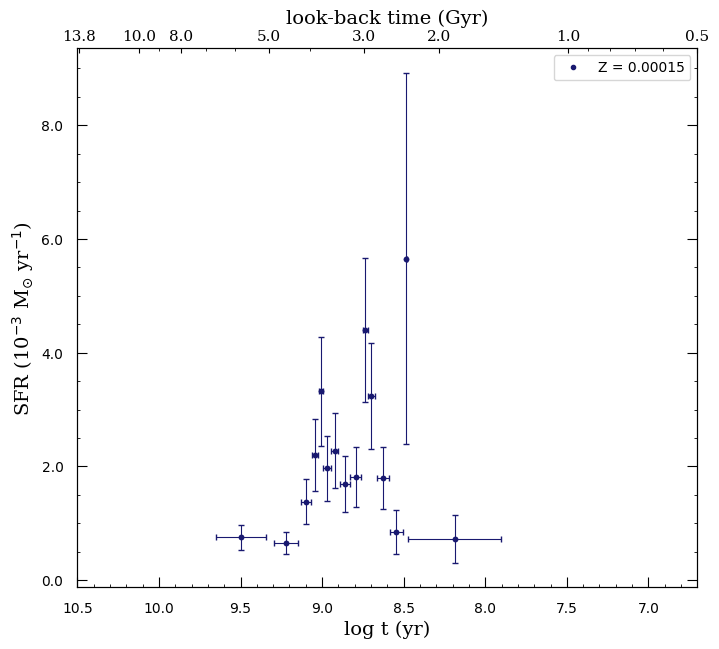

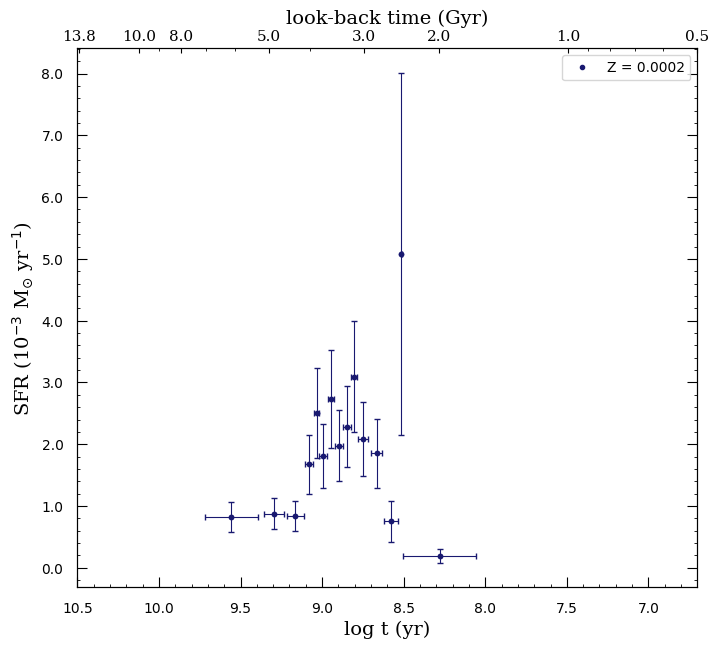

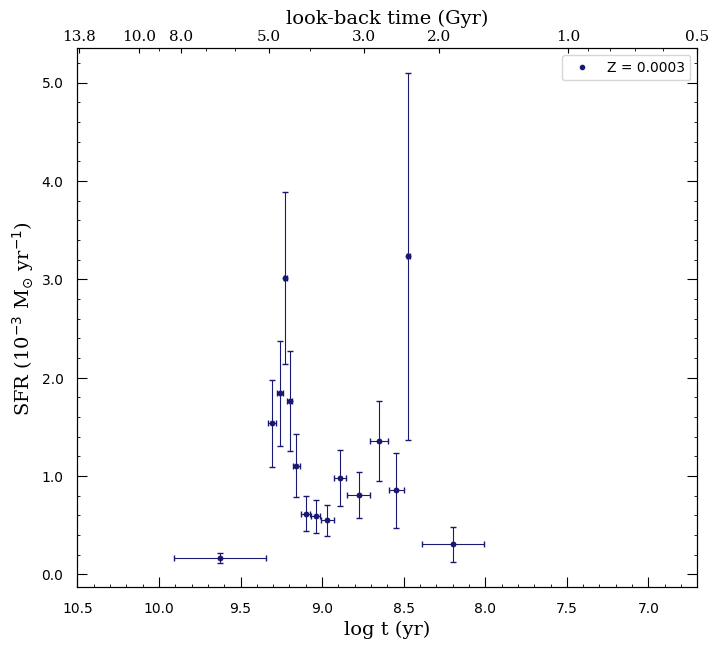

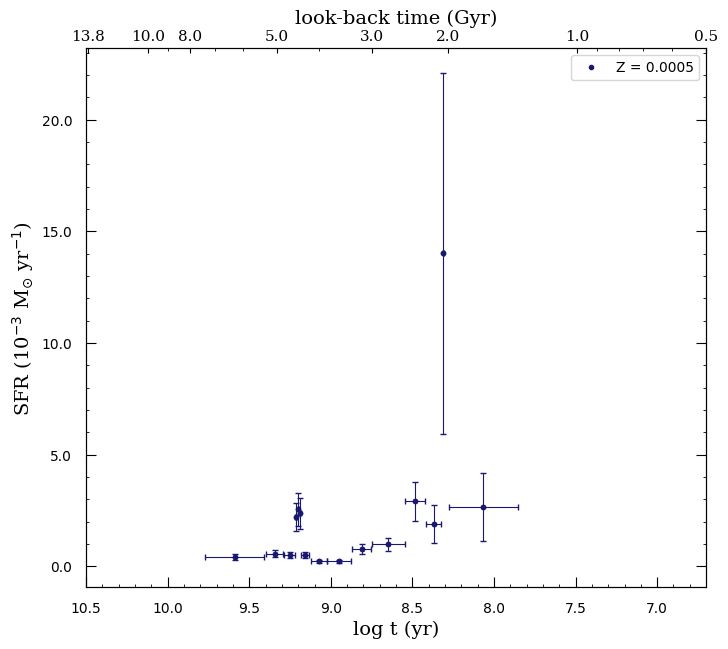

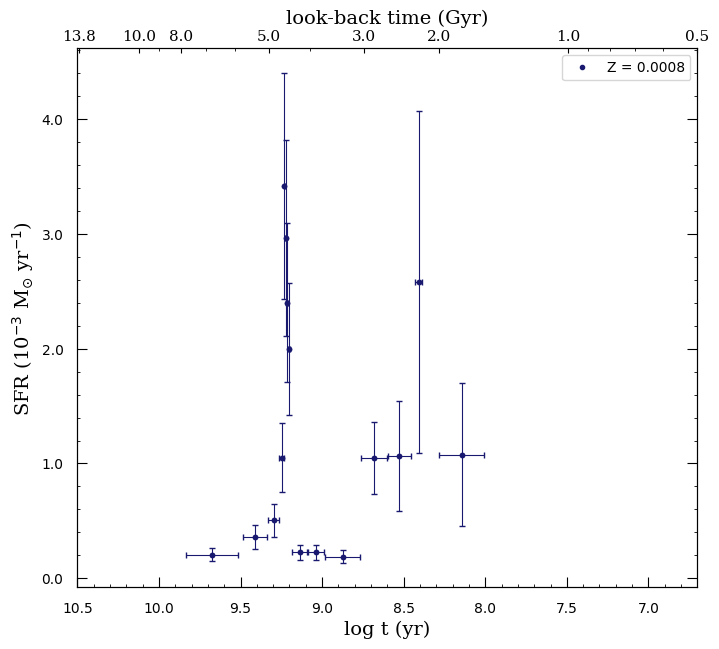

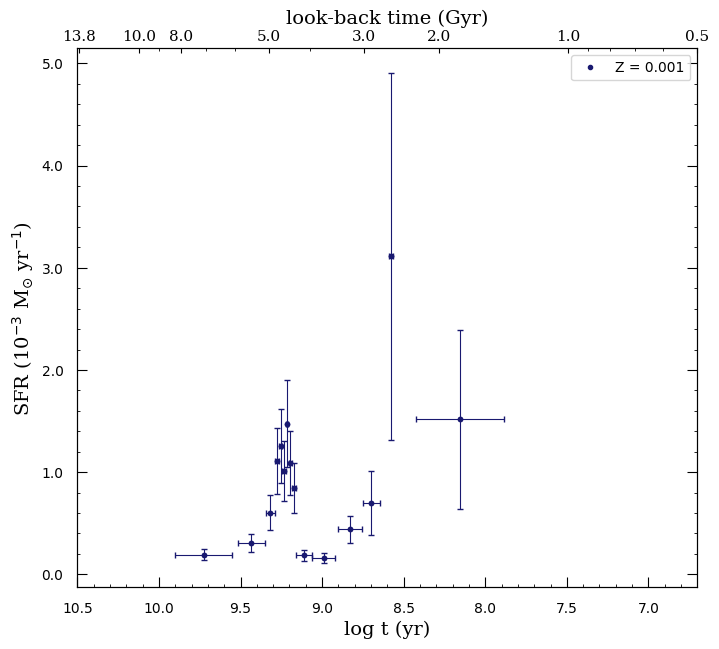

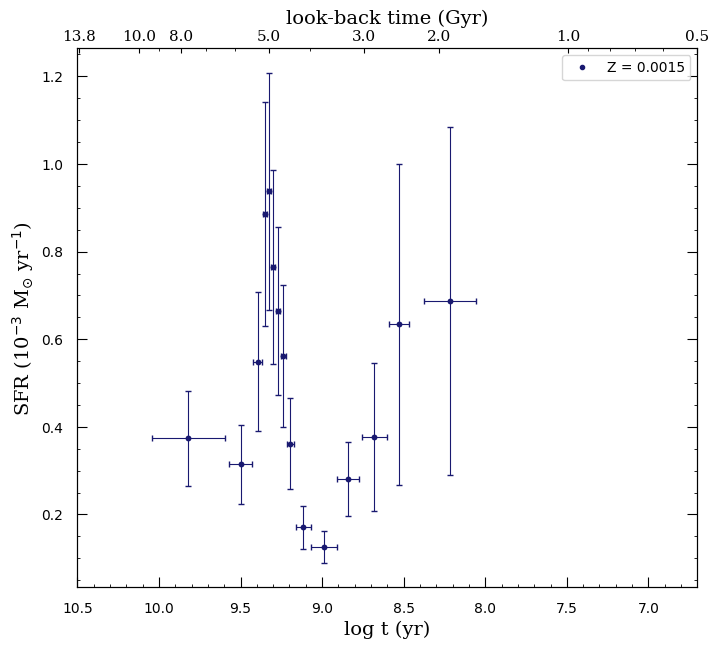

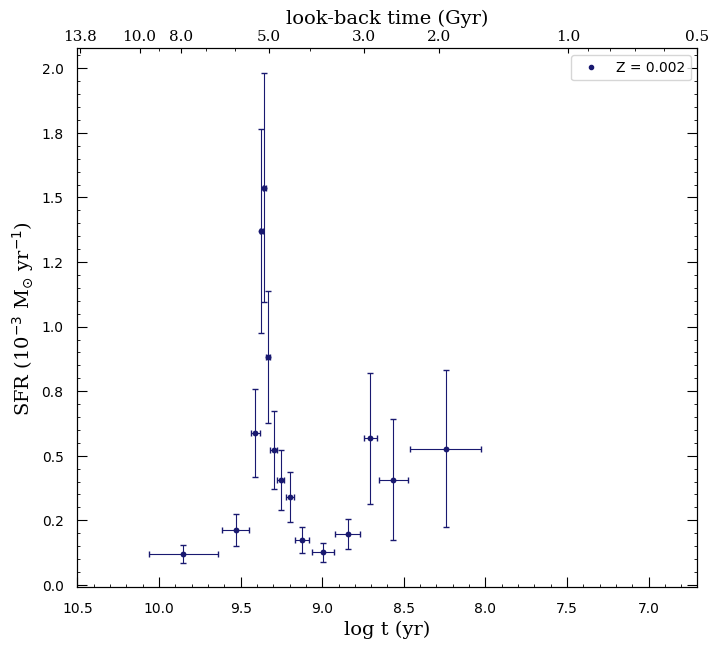

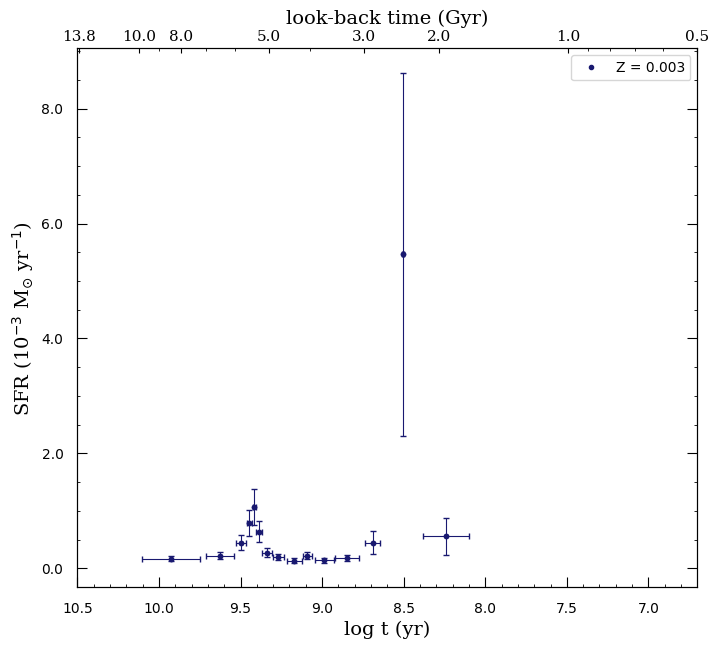

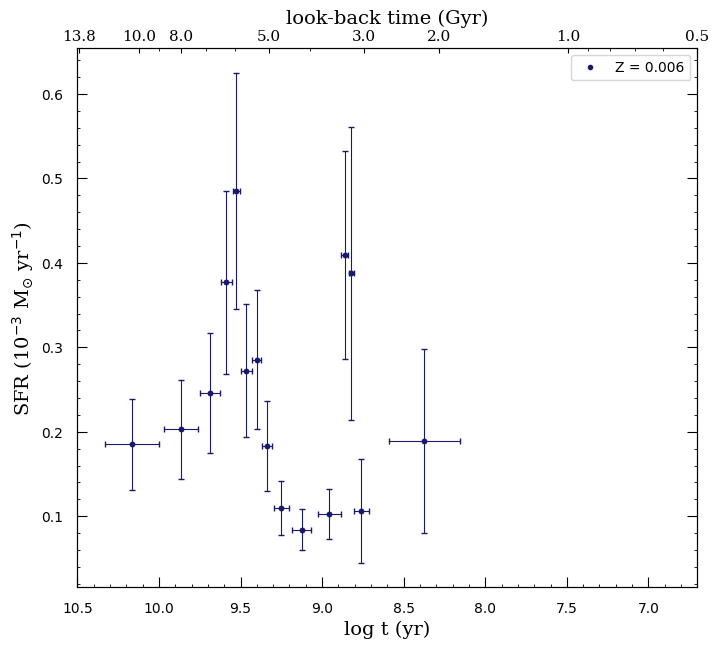

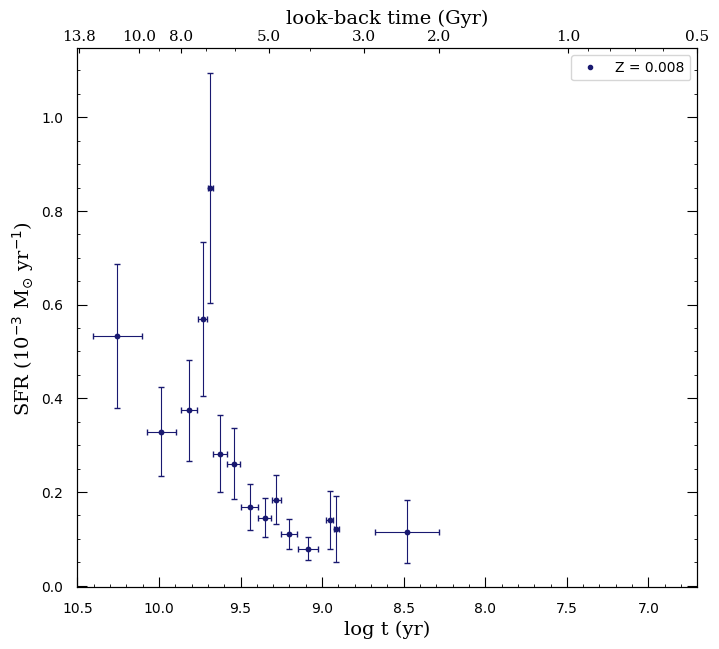

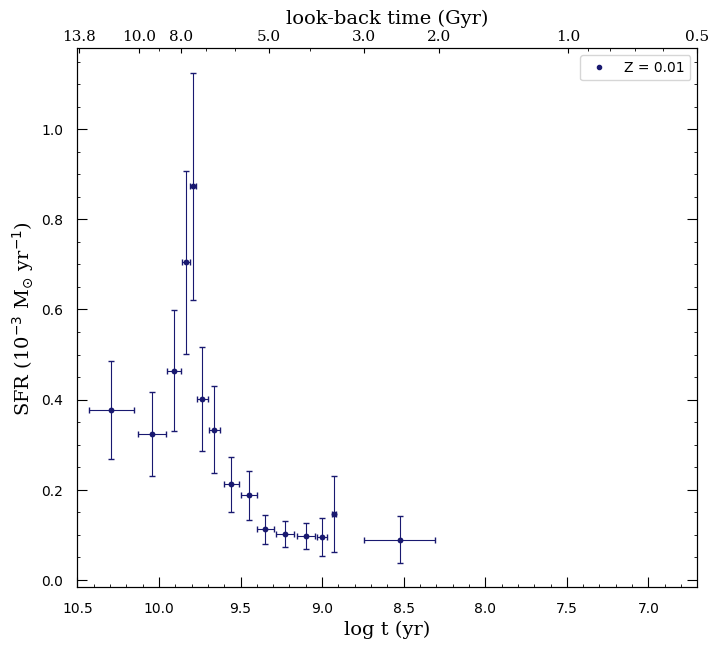

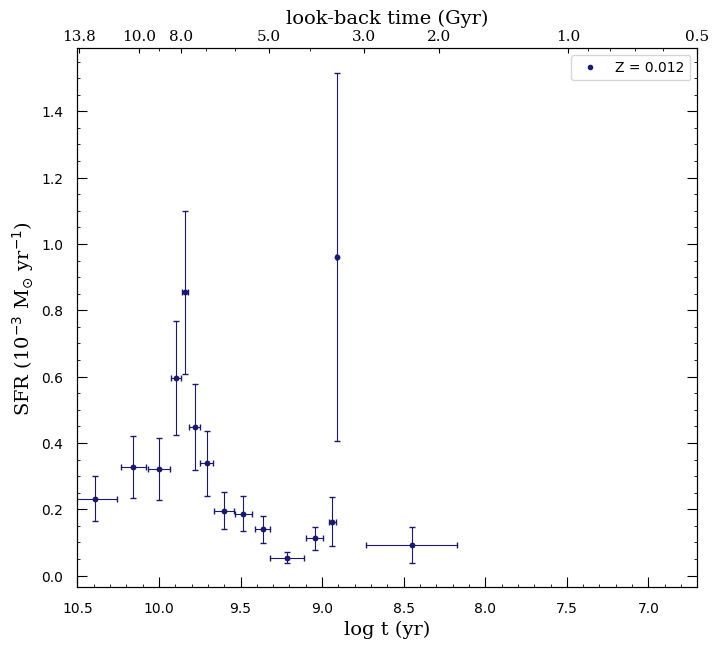

In [ ]:
Z = [0.0001,0.00015,0.0002,0.0003,0.0005,0.0008,
     0.001,0.0015,0.002,0.003,0.006,0.008,
     0.01,0.012]
for w in Z : 
  Z_name = ''.join(list(str(w))[2:])
  df = pd.read_csv('/content/NGC_6822/Data_Correction_v2/NGC6822_LPV_Data_'+Z_name+'.csv')
  df = df.merge(df_loc, how='inner', on = ['Ra(J2000) deg','Dec(J2000) deg'])
  df = df[df['Body'] == 1 ]

  #Sorting By t (Age of LPV Stras)
  df = df.sort_values(by='t', ascending=False)
  df = df.reset_index()

  #Finding Alpha
  df['alpha'] = np.nan
  for k in df.index:
    if df.loc[k,'M/Ms'] < 0.08 :
      df.loc[k,'alpha'] = 0.3
    elif df.loc[k,'M/Ms'] >= 0.5 :
      df.loc[k,'alpha'] = 2.3
    else :
      df.loc[k,'alpha'] = 1.3 

  # Whole Region
  # Setting populatopn of each bins 
  bins_number = 12
  bins_with_more_stars = 1
  bins_pop = ([12]*(bins_number-bins_with_more_stars)) + ([11]*bins_with_more_stars) + ([5]) + ([3]*2)

  #SFH Calcualtion
  lower_index = 0
  sub_integration = 0
  
  sub_integration = integrate.quad(lambda m: m * m**-0.3 , 0.02, 0.08)[0] \
                    + integrate.quad(lambda m: m * m**-1.3 , 0.08, 0.5)[0] \
                      + integrate.quad(lambda m: m * m**-2.3 , 0.5, 200)[0]

  log_t = []
  log_t_err = []

  XI = []
  XI_err = []

  alpha =[]
  M_lower_limit = []
  M_upper_limit = []
  log_t_lower_limit = []
  log_t_upper_limit = []

  for i in bins_pop :

    selected_df = df[lower_index:lower_index+i]

    # Calculating limitation of each bin 
    M_lower_limit_ = selected_df.iloc[0]['M/Ms']
    M_upper_limit_ = selected_df.iloc[-1]['M/Ms']
    alpha_ = selected_df.iloc[0]['alpha']
    log_t_lower_limit_ = selected_df.iloc[-1]['Log(t)']
    log_t_upper_limit_ = selected_df.iloc[0]['Log(t)']

    # Adding to lists
    alpha.append(alpha_)
    M_lower_limit.append(M_lower_limit_)
    M_upper_limit.append(M_upper_limit_)
    log_t_lower_limit.append(log_t_lower_limit_)
    log_t_upper_limit.append(log_t_upper_limit_)

    # Calculating XI
    p1 = sum(1/selected_df['dt'])
    p2 = sub_integration
    p3 , err = integrate.quad(lambda m: m**(-alpha_) , M_lower_limit_, M_upper_limit_)
    
    XI_ = p1 * p2 * (1/p3) / S_body * 1000
    XI_err_ = XI_ * ((i**0.5)/i) 

    log_t.append((log_t_lower_limit_ + log_t_upper_limit_)/2)
    log_t_err.append((log_t_upper_limit_ - log_t_lower_limit_ )/2)
    XI.append(XI_)
    XI_err.append(XI_err_)

    lower_index += i
    
  # Making Data frame for SFH calculation
  columns = ['log(t) (lower limit)' , 'log(t) (upper limit)',
            'M (lower limit)', 'M (upper limit)' , 'Alpha' , 'Mean log(t)',
            'Mean log(t) error' , 'XI' , 'XI error']
  
  # Calling DataFrame constructor after zipping
  # both lists, with columns specified
  SFH_df = pd.DataFrame(list(zip(log_t_lower_limit, log_t_upper_limit,
                                M_lower_limit,M_upper_limit,alpha,log_t,
                                log_t_err,XI,XI_err)), columns =columns)

  #Plot
  plt.figure(figsize = (8,7), dpi = 100)

  plt.xlabel('log t (yr)', {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})
  plt.ylabel('SFR (10$^{-3}$ M$_{\odot}$ yr$^{-1}$)',
            {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})

  plt.tick_params(axis='both', which='major', length=7, pad=10, direction='in')
  plt.tick_params(axis='y', which='both', left=True, direction='in')
  plt.tick_params(axis='x', which='both', bottom=True, direction='in')
  plt.tick_params(axis='x', which='both', top=True, direction='in')
  plt.tick_params(axis='y', which='both', right=True, direction='in')

  plt.minorticks_on()

  plt.xlim(10.5,6.7)

  plt.plot( SFH_df['Mean log(t)'] , SFH_df['XI'] , '.', color = 'midnightblue', label = 'Z = ' + str(w))
  plt.errorbar(SFH_df['Mean log(t)'], SFH_df['XI'] ,
              SFH_df['XI error'] ,SFH_df['Mean log(t) error'], fmt='.', color='midnightblue', capsize=2.5, linewidth=0.8)

  plt.legend()

  ###########################################
  ax2 = plt.twiny()

  ax2.xaxis.tick_top()
  ax2.yaxis.tick_right()
  ax2.set_xlim(13.96,0.575)

  ax2.set_xscale('log')

  ax2.set_xlabel('look-back time (Gyr)', {'color': 'k', 'fontsize': 14,'fontname':'serif','alpha':1})
  ax2.xaxis.set_label_position('top') 
  ax2.yaxis.set_label_position('right') 
  ax2.set_xticks((13.8,10,8,5,3,2,1,0.5))
  ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter(useOffset=None, useMathText=None, useLocale=None))
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=12,fontname = "serif")
  ax2.set_xticklabels(ax2.get_xticks(), fontsize=11,fontname = "serif")

  ax2.tick_params(axis='x',which='both',bottom= False,top= True,direction='in')#,color='red',width=5)
  ax2.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
  ax2.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
  ###########################################

  #Saving Data
  SFH_df.to_csv('/content/Body/NGC6822_SFH_Data_Body_'+ Z_name +'.csv', index=False)
  plt.savefig('/content/Body/SFR_Body_'+Z_name+'.jpeg', bbox_inches='tight', dpi = 400)

# Downloading Data

In [ ]:
!zip -r /content/Whole_Area.zip /content/Whole_Area

In [ ]:
!zip -r /content/Body.zip /content/Body

In [ ]:
!zip -r /content/Bulge.zip /content/Bulge